In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

# Useful Functions

In [2]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

# Load Pre-Processed Data Croppings
see preprocessing.ipynb

In [40]:
def loadCroppings(data_dir, image_croppings_dir, mask_croppings_dir=""):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    
    X = []
    Y = []
    croppings_count = np.zeros(len(image_ids), dtype=np.uint8)
    
    for i, imgID in enumerate(image_ids):
        path_images = f"{data_dir}/{imgID}/{image_croppings_dir}"
        croppings = sorted(os.listdir(path_images))
        croppings_count[i] = len(croppings)
        for c in croppings:
            X.append(np.array(Image.open(f"{path_images}/{c}")))

        if mask_croppings_dir:
            path_masks = f"{data_dir}/{imgID}/{mask_croppings_dir}"
            for c in sorted(os.listdir(path_masks)):
                Y.append(np.array(Image.open(f"{path_masks}/{c}")))
        
    return np.array(X), np.array(Y), image_ids

In [41]:
X_train, Y_train, imageIDs_train = loadCroppings("./data/stage1_train", "image_croppings", "mask_croppings")
X_val, Y_val, imageIDs_val = loadCroppings("./data/stage1_test", "image_croppings", "mask_croppings")

# Only Load During Testing
# X_test, _, imageIDs_test = loadCroppings("./data/stage2_test_final", "image_croppings")

In [27]:
len(X_train)

7315

Cropping


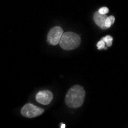

[[2 2 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]
 [2 0 0 ... 2 0 3]
 ...
 [0 0 0 ... 2 6 8]
 [0 0 0 ... 2 6 6]
 [0 0 0 ... 5 5 5]]
Mask


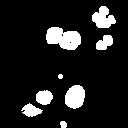

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
print("Cropping")
display(Image.fromarray(X_train[12], 'L'))
print(X_train[12])
print("Mask")
display(Image.fromarray(Y_train[12], 'L'))
print(Y_train[12])

# Train Model

In [18]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [19]:
def create_model(input_shape, LR):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(), #learning_rate=LR
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [48]:
batch_size = 16
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 25
LR = 0.0001
stopping_patience = 10
stopping_delta = 0.001

model = create_model((128, 128, 1), LR)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 128, 128, 64  256        ['conv2d_77[0][0]']              
 ormalization)                  )                                                           

In [49]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_val, Y_val),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/25
458/458 [==============================] - 18s 36ms/step - loss: -425.7847 - accuracy: 0.7149 - val_loss: -502.6642 - val_accuracy: 0.5443
Epoch 2/25
458/458 [==============================] - 16s 35ms/step - loss: -445.5462 - accuracy: 0.6791 - val_loss: -501.9234 - val_accuracy: 0.1651
Epoch 3/25
458/458 [==============================] - 16s 35ms/step - loss: -445.5782 - accuracy: 0.6659 - val_loss: -501.1929 - val_accuracy: 0.25742s - loss: -445.8085 - ac - ETA: 1s - loss: -444.7369 -
Epoch 4/25
458/458 [==============================] - 16s 35ms/step - loss: -445.7549 - accuracy: 0.6813 - val_loss: -503.5583 - val_accuracy: 0.5769
Epoch 5/25
458/458 [==============================] - 16s 35ms/step - loss: -445.8022 - accuracy: 0.6849 - val_loss: -477.1536 - val_accuracy: 0.6624
Epoch 6/25
458/458 [==============================] - 16s 35ms/step - loss: -445.7349 - accuracy: 0.6837 - val_loss: -503.5149 - val_accuracy: 0.5608
Epoch 7/25
458/458 [=========================

Training set Accuracy: 0.7948
Training set Loss:-314.494934

Validation set Accuracy: 0.7380
Validation set Loss:-236.272644



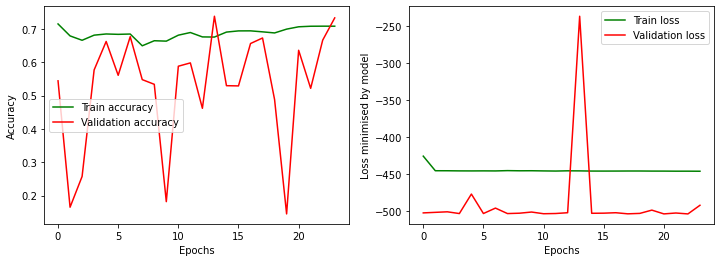

In [50]:
[train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(results)

## Testing

In [ ]:
# Load Test Data
X_test, _, imageIDs_test = loadCroppings("./data/stage2_test_final", "image_croppings")

In [36]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
#preds_test = model.predict(X_test, verbose=1)

26/26 [==============================] - 0s 15ms/step


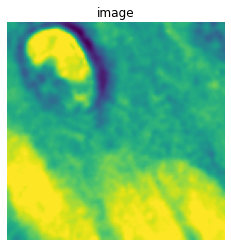

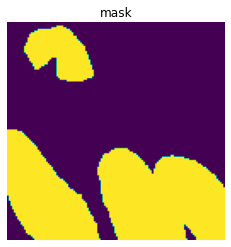

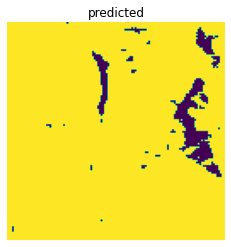

In [39]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_val_t))
display_img(X_val[ix], title="image")
display_img(Y_val[ix], title="mask")
display_img(preds_val_t[ix], title="predicted")

In [13]:
ix

78

## Export Predicted masks to CSV

In [15]:
testset_predictions = (preds_test > 0.5).astype(np.uint8)

In [56]:
template_csv = "./data/stage2_sample_submission_final.csv"
image_dir = "./data/stage2_test_final"
output_csv = "submission_test.csv"

show_no_nuclei_images = False

print(f"Saving {testset_predictions.shape[0]} predictions")
with open(output_csv, 'w', newline='') as output_csvfile:
    writer = csv.DictWriter(output_csvfile, fieldnames=["ImageId", "EncodedPixels"])
    writer.writeheader()
    total_nucleus_count = 0
    
    progress_indices = np.linspace(0, testset_predictions.shape[0], 21, dtype=int)
    
    with open(template_csv, newline='') as template_csvfile:
        for i, (imgID, _) in enumerate(csv.reader(template_csvfile, delimiter=',')):
            if i == 0: # Skip row with labels
                continue

            # Get Prediction For ImgID
            prediction = testset_predictions[imageIDs_test.index(imgID)]

            # TODO reconstruct mask predictions into original size
            # Scale Predicted Mask Back To Original Image Size
            original_image_size = Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}").size
            predicted_mask = tf.keras.utils.img_to_array(
                tf.image.resize(prediction, original_image_size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            )[:, :, 0]
            
            predicted_mask_T = predicted_mask.transpose()
            
            # Label each nucleus in mask
            (labeled_mask, nucleus_amount) = skimage.measure.label(predicted_mask_T, connectivity=2, background=0, return_num=True)
            total_nucleus_count += nucleus_amount
            if nucleus_amount == 0 and show_no_nuclei_images:
                print(f"No nuclei found for image {imgID}")
                try:
                    display_img(Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}"))
                except:
                    print(f"Error while displaying image {imgID}")
            
            # Calculate RLE
            RLE = [[] for _ in range(nucleus_amount)]
            curr_pixel = 1
            run_length = 0
            run_label = 0
            
            for i_c, c in enumerate(labeled_mask):
                for i_r, x in enumerate(c):
                    if x:
                        if run_length == 0 or run_label != x:
                            if run_length > 0:
                                RLE[run_label-1].append(run_length)
                                run_length = 0
                            RLE[x-1].append(i_c * labeled_mask.shape[1] + i_r + 1)
                            run_label = x
                        run_length += 1
                    elif run_length > 0:
                        RLE[run_label-1].append(run_length)
                        run_length = 0
                        run_label = 0
            if run_length > 0:
                RLE[run_label-1].append(run_length)
            
            # Write To output file
            for nucleus_RLE in RLE:
                writer.writerow({"ImageId": imgID, "EncodedPixels": ' '.join(map(str, nucleus_RLE))})
            
            if nucleus_amount == 0: # default entry
                writer.writerow({"ImageId": imgID, "EncodedPixels": ''})
            
            # Show sign of progress
            if i in progress_indices:
                print(f"{np.where(progress_indices == i)[0][0] * 5}%")
    
    print()
    print(f"Found {total_nucleus_count} nuclei in {testset_predictions.shape[0]} images")

Saving 3019 predictions
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%

Found 72769 nuclei in 3019 images


#### Architectures to try out 

Attention U-net

Residual U-Net

Mask R-CNN

Basic Unet + ResNet encoder